In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from sys import exit
from matplotlib.backends.backend_pdf import PdfPages 
import matplotlib.dates as mdates
import seaborn as sns
from calendar import monthrange
import datetime
from tqdm import tqdm
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

In [2]:
def Create_PDFs(Filename,Identifier): 
    p = PdfPages(Filename) 
    fig_nums = plt.get_fignums()   
    figs = [plt.figure(n) for n in fig_nums] 
    #for fig in tqdm(figs, desc=f'  Plotting {Identifier} ...'):
    for fig in figs:  
        fig.savefig(p, format='pdf')  
    p.close()
#
def GetCoeffVariation (listofval): # Co-efficient of variation (CV)
    MeanVal = sum(listofval)/len(listofval)
    StdDev = np.std(listofval)
    # Standard deviation divided by the mean, lower the better (more stable).
    VolRatio = abs(StdDev/MeanVal) 
    return (round(VolRatio,5))
#
def ApplySunHours(Year,Month):
    SunHours = SunHoursDF.loc[(SunHoursDF["Year"] == Year) & (SunHoursDF["Month"] == Month)]["SunHours"].values[0]
    return SunHours
#
def Average(numberslist):
    return (round(sum(numberslist)/len(numberslist),2))
def MaxValue(numberslist):
    return (max(numberslist))
def MinValue(numberslist):
    return (min(numberslist))

In [3]:
Profiles = {
    'Profile_A':[18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18,18],
    'Profile_B':[18,18,18,18,18,18,20,20,20,18,18,18,18,18,18,18,20,20,20,20,20,20,18,18],
    'Profile_C':[20,20,20,20,20,20,18,18,18,20,20,20,20,20,20,20,18,18,18,18,18,18,20,20],
    'Profile_D':[18,18,18,18,18,18,21,21,21,18,18,18,18,18,18,18,21,21,21,21,21,21,18,18],
}
NoOfHP = 30 # in million
#
def ResidentialHP_A(OutTemp,Month,UK_HTC): # 'ResidentialHP_A' HP always operating during Winter and Summer.
    if len(OutTemp) != 24:
        exit(f"24 number of outside temp not provided. Actual {len(OutTemp)}. Exiting...")
    HeatLossThermal = UK_HTC*126.57*1.25 # 1.8W/m2K times 126.57m2*1.25 to include floors and roofs.
    HPPowerUse_E = []
    for OutT,InsideTemp in zip(OutTemp,CoolingProfile):
        dT = abs(InsideTemp-OutT)
        COP = getCOP(dT,InsideTemp,Month)
        HeatPumpElec = round((HeatLossThermal*dT/COP)*NoOfHP,2) # in MWe
        HPPowerUse_E.append(HeatPumpElec)
    return(HPPowerUse_E)
#
InHighTemp = 25
def ResidentialHP_B(OutTemp,Month,AirToAirAdoptionRate,UK_HTC): 
    # 'ResidentialHP_B' HP always operating during winter, during summer operates till IAT reaches 25C; In Summer less than 25 the HP power use is Zero.
    if len(OutTemp) != 24:
        exit(f"24 number of outside temp not provided. Actual {len(OutTemp)}. Exiting...")
    HeatLossThermal = UK_HTC*126.57*1.25 # 1.8W/m2K times 126.57m2*1.25 to include floors and roofs.
    HPPowerUse_E = []
    for OutT,InsideTemp in zip(OutTemp,CoolingProfile):
        if (InsideTemp-OutT) > 0:                               # Winter time, Heating required.
            dT = InsideTemp-OutT
            COP = getCOP(dT,InsideTemp,Month)
            HeatPumpElec = round((HeatLossThermal*dT/COP)*NoOfHP,2) # in MWe
            HPPowerUse_E.append(HeatPumpElec)
        elif (InsideTemp-OutT) < 0 and (OutT >= InHighTemp): # Summer, Cooling till 25C required - Hot summer
            dT = OutT-InHighTemp
            COP = getCOP(dT,InsideTemp,Month)
            HeatPumpElec = round((HeatLossThermal*dT/COP)*NoOfHP*AirToAirAdoptionRate/100,2) # in MWe
            HPPowerUse_E.append(HeatPumpElec)
        else:                                                   # Warm but but not hot.
            HPPowerUse_E.append(float(0))
    return(HPPowerUse_E)

In [4]:
def getCOP(dT,InsideTemp,Month):
    SoilTemp = {1:6.079032,2:5.880090,3:6.188341,4:8.265506,5:11.297607,6:14.157917, # Average Soil temperature in Shefffield
                7:15.928495,8:16.968100,9:15.952500,10:13.576498,11:11.006667,12:8.050320}
    #
    GSHPdT = abs(InsideTemp-SoilTemp[Month])
    WSHPdT = abs(10-InsideTemp)
    #
    ASHPCOP = 6.08-0.09*dT+0.0005*dT*dT       # As Literature.
    #ASHPCOP = 4.08-0.09*dT+0.0008*dT*dT        # As evaluated from the Heat Pump demonstration project.
    GSHPCOP = 10.29-0.21*GSHPdT+0.0012*GSHPdT*GSHPdT  # As Literature.
    WSHPCOP = 9.97-0.20*WSHPdT+0.0012*WSHPdT*WSHPdT   # As Literature.
    # Weighted Average, Roughly even distribution of ASHP, and GSHP and WSHP (district heating).
    WAverage = (0.5*ASHPCOP)+(0.3*GSHPCOP)+(0.2*WSHPCOP)
    return (WAverage)

In [5]:
Month = {1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',
         7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
Seasons = {1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',
         7:'Summer',8:'Summer',9:'Autumn',10:'Autumn',11:'Autumn',12:'Winter'}
DayName = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
WeekDayWeekend = {0:'Weekday',1:'Weekday',2:'Weekday',3:'Weekday',4:'Weekday',5:'WeekEnd',6:'WeekEnd'}
MonthlyDaylight = {1:8.4,2:10.1,3:11.9,4:14.0,5:15.7,6:16.7,\
                   7:16.2,8:14.7,9:12.7,10:10.8,11:8.9,12:7.9} # SOURCE: https://www.worlddata.info/europe/united-kingdom/sunset.php

In [6]:
# For Hourly
HourlyDF = pd.read_csv("0.DataSource/National Demand/df_fuel_ckan_DemandPriceTemp_Hourly.csv")
HourlyDF['DATETIME'] = pd.to_datetime(HourlyDF['DATETIME'])
HourlyDF = HourlyDF.loc[(HourlyDF['DATETIME'].dt.year >= 2009) & (HourlyDF['DATETIME'].dt.year <= 2023)]
#
HourlyDF['Year'],HourlyDF['Month'],HourlyDF['Day'],HourlyDF['WeekNumber'],HourlyDF['DaysOfTheYear'],\
    HourlyDF['DayOfTheWeek'],HourlyDF['Hour'] = HourlyDF['DATETIME'].dt.year,\
    HourlyDF['DATETIME'].dt.month,HourlyDF['DATETIME'].dt.day,HourlyDF['DATETIME'].dt.isocalendar().week,\
    HourlyDF['DATETIME'].dt.dayofyear,HourlyDF['DATETIME'].dt.dayofweek,HourlyDF['DATETIME'].dt.hour
HourlyDF['Seasons'] = HourlyDF['Month'].map(Seasons)
HourlyDF['WeekDay_OR_Weekend'] = HourlyDF['DayOfTheWeek'].map(WeekDayWeekend)
HourlyDF.insert(2,'Seasons',HourlyDF.pop('Seasons'))

In [7]:
def DataTableOption(Option,AirToAirAdoptionRate,UK_HTC):
    DataTable = pd.DataFrame(columns=['Date','Year','Month','Day','DayOfTheYear',
                                      'Day Avg Demand','Day Max Demand','Day Avg HPe','Day Max HPe','Min Demand With HP','Avg Demand With HP','Max Demand With HP',
                                      'DayDemand_CV','DayHP_CV','DayDemandHPCombined_CV','DayDemandToHP_CV_Change',
                                      'Demand profile, MWe','HP Profile, MWe','Demand profile with HP, MWe',
                                      'Temperature Profile,C'])
    StartingYear = 2009
    EndYear = 2022
    #Years = tqdm(range(StartingYear,EndYear+1))
    #for Year in Years:
    for Year in range(StartingYear,EndYear+1):
        ValueYEAR = HourlyDF.loc[(HourlyDF['Year'] == Year)]
        YearDay = 0
        for Month in range(1,12+1):
            #Years.set_description(f'{Year}-{Month} ##>>')
            ValueMONTH = ValueYEAR.loc[(ValueYEAR['Month'] == Month)]
            Days = monthrange(Year,Month)[1]
            for Day in range(1,Days+1):
                Date = datetime.date(Year,Month,Day)
                DataList = []
                YearDay += 1
                ValueDAY = ValueMONTH.loc[(ValueMONTH['Day'] == Day)]
                #
                # Profiles and Lists
                DailyDemandList = ValueDAY['NATIONAL DEMAND'].tolist() # National Demand
                DailyTempList = ValueDAY['Air_Temperature'].tolist()
                #
                if Option == 'A':
                    HPProfileMWe = ResidentialHP_A(DailyTempList,Month,UK_HTC)                        # Just HP
                elif Option == 'B':
                    HPProfileMWe = ResidentialHP_B(DailyTempList,Month,AirToAirAdoptionRate,UK_HTC)   # Just HP
                else:
                    exit("Valid Option not received.")
                #
                DemandProfileWithHPMWe = np.array(DailyDemandList)+np.array(HPProfileMWe)  # National Demand + HP
                #
                # Average Values
                DayMEANDemand = Average(DailyDemandList)               # National Demand
                DayMEANHPe = Average(HPProfileMWe)                     # Just HP
                DayMEANDemandAndHPe = Average(DemandProfileWithHPMWe)  # National Demand + HP
                #
                # Min Values
                DayMINDemandAndHPe = MinValue(DemandProfileWithHPMWe)  # National Demand + HP
                #
                # Max Values
                DayMAXDemand = MaxValue(DailyDemandList)               # National Demand
                DayMAXHPe = MaxValue(HPProfileMWe)                     # Just HP
                DayMAXDemandAndHPe = MaxValue(DemandProfileWithHPMWe)  # National Demand + HP
                #
                # CV Values
                DayCV_Demand = GetCoeffVariation(DailyDemandList)               # National Demand
                DayCV_HPe = GetCoeffVariation(HPProfileMWe)                     # Just HP
                DayCV_DemandAndHPe = GetCoeffVariation(DemandProfileWithHPMWe)  # National Demand + HP 
                DayCV_Delta = DayCV_Demand - DayCV_DemandAndHPe                 # Coefficient of Varience change from Demand and (Demand + HP). +ve means it became more stable, -ve means it got worse.
                #
                DataList.extend([Date,Year,Month,Day,YearDay,DayMEANDemand,DayMAXDemand,DayMEANHPe,DayMAXHPe,DayMINDemandAndHPe,DayMEANDemandAndHPe,DayMAXDemandAndHPe])
                DataList.extend([DayCV_Demand,DayCV_HPe,DayCV_DemandAndHPe,DayCV_Delta])
                DataList.append(DailyDemandList)
                DataList.append(HPProfileMWe)
                DataList.append(DemandProfileWithHPMWe.tolist())
                DataList.append(DailyTempList)
                #
                DataTable.loc[len(DataTable), DataTable.columns] = (DataList)
    DataTable['Seasons'] = DataTable['Month'].map(Seasons)
    DataTable.insert(3,'Seasons',DataTable.pop('Seasons'))
    return DataTable
#DataTable.to_csv("GenWithHP.csv",index=False)            

In [8]:
# in MILES # UK, Department of Transport, 2019 data. 2020,2021,2022 are availiable however are discounted.
Miles = np.array([0,1,2,5,10,25,50,100,300])
PecentOfCarsMiles = np.array([0.0000,0.0043,0.0253,0.1156,0.1616,0.2828,0.1652,0.1143,0.1308])
if (round(sum(PecentOfCarsMiles),2) != 1):
    exit(f"The provided 'PecentrOfCars' must add up to one, current ({round(sum(PecentOfCarsMiles),2)}). Exiting ...")
#
def CarsCharged(Year,Season,DemandProfile,MilesPerkWh):
    kWhEqu = Miles/MilesPerkWh
    TotalPower100Cars = sum(np.multiply(kWhEqu,PecentOfCarsMiles)*100) # 2226.66
    NoOfCarsfor1000kWe = 100/(TotalPower100Cars/1000)  # For 1000kWe or 1MWe.
    #
    SeasonalMax = SeasonalMaxDemandWithHP.loc[Year,Season].values[0]
    Values = []
    for hourlydemand in DemandProfile:
        PowerToThreshold = SeasonalMax - hourlydemand
        DailyCarsBeingCharged = PowerToThreshold*NoOfCarsfor1000kWe/1000000 # List of cars being charged every hour, in millions.
        Values.append(DailyCarsBeingCharged)
    return (sum(Values))

In [26]:
#Varient = 'ASHP COP HP Demonstration Project'
Varient = 'ASHP COP Literature'
CoolingProfileLabel = 'Profile_A';CoolingProfile = Profiles[CoolingProfileLabel];
Plan = 'B';AirToAirAdoptionRate = 60
#
SummaryDF = pd.DataFrame(columns=["Varient","UK HTC","Car Miles per kWh",\
                                  "MaxDemand_0Percentile","MaxDemand_25Percentile","MaxDemand_50Percentile","MaxDemand_75Percentile","MaxDemand_80Percentile","MaxDemand_100Percentile",\
                                  "CarsCharged_0Percentile","CarsCharged_25Percentile","CarsCharged_50Percentile","CarsCharged_75Percentile","CarsCharged_80Percentile","CarsCharged_100Percentile",\
                                 ])
DataTable18 = DataTableOption(Plan,AirToAirAdoptionRate,1.8)
SeasonalMaxDemandWithHP18 = pd.pivot_table(DataTable18, values='Max Demand With HP', index=['Year','Seasons'],aggfunc='max')
#
for UK_HTC in np.arange(0.5,2.6,0.1):
    UK_HTC = round(UK_HTC,1)
    print(f"\nUK HTC {UK_HTC} W/m2K --",end=" ")
    for MilesPerkWh in np.arange(2,7.1,0.1):
        MilesPerkWh = round(MilesPerkWh,1)
        print(f"# ",end="")
        DataList = []
        DataTableTotalCarCharged = pd.DataFrame()
        #
        if UK_HTC <= 1.8:
            DataTable = DataTable18
            SeasonalMaxDemandWithHP = SeasonalMaxDemandWithHP18
        else:
            DataTable = DataTableOption(Plan,AirToAirAdoptionRate,UK_HTC)
            SeasonalMaxDemandWithHP = pd.pivot_table(DataTable, values='Max Demand With HP', index=['Year','Seasons'],aggfunc='max')
        DataTable['TotalCarsCharged'] = np.vectorize(CarsCharged)(DataTable['Year'],DataTable['Seasons'],DataTable['Demand profile with HP, MWe'],MilesPerkWh)
        #
        DataTableTotalCarCharged = DataTable[['TotalCarsCharged',"Date","Seasons","Max Demand With HP","Day Max HPe"]]
        #
        MDHP0,MDHP25,MDHP50,MDHP75,MDHP80,MDHP100 = np.percentile(DataTableTotalCarCharged["Max Demand With HP"], [0,25,50,75,80,100]) # Max demand with HP percentiles
        CC0,CC25,CC50,CC75,CC80,CC100 = np.percentile(DataTableTotalCarCharged["TotalCarsCharged"], [0,25,50,75,80,100]) # Cars Charged (in millions) percentiles.
        #
        DataList.extend([Varient,UK_HTC,MilesPerkWh,MDHP0,MDHP25,MDHP50,MDHP75,MDHP80,MDHP100,CC0,CC25,CC50,CC75,CC80,CC100])
        SummaryDF.loc[len(SummaryDF), SummaryDF.columns] = (DataList)
SummaryDF.to_csv("3.Methodology/3_EV_Charging/EV_Charging_FixedTill18_HP_COP_Literature.csv", index=False)
print("\nCompleted")


UK HTC 0.5 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 0.6 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 0.7 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 0.8 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 0.9 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 1.0 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 1.1 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 1.2 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 1.3 W/m2

In [27]:
CoolingProfileLabel = 'Profile_A';CoolingProfile = Profiles[CoolingProfileLabel];
Plan = 'B';AirToAirAdoptionRate = 60
#
SummaryDF = pd.DataFrame(columns=["Varient","UK HTC","Car Miles per kWh",\
                                  "MaxDemand_0Percentile","MaxDemand_25Percentile","MaxDemand_50Percentile","MaxDemand_75Percentile","MaxDemand_80Percentile","MaxDemand_100Percentile",\
                                  "CarsCharged_0Percentile","CarsCharged_25Percentile","CarsCharged_50Percentile","CarsCharged_75Percentile","CarsCharged_80Percentile","CarsCharged_100Percentile",\
                                 ])
#
for UK_HTC in np.arange(0.5,2.6,0.1):
    UK_HTC = round(UK_HTC,1)
    print(f"\nUK HTC {UK_HTC} W/m2K --",end=" ")
    for MilesPerkWh in np.arange(2,7.1,0.1):
        MilesPerkWh = round(MilesPerkWh,1)
        print(f"# ",end="")
        DataList = []
        DataTableTotalCarCharged = pd.DataFrame()
        #
        DataTable = DataTableOption(Plan,AirToAirAdoptionRate,UK_HTC)
        SeasonalMaxDemandWithHP = pd.pivot_table(DataTable, values='Max Demand With HP', index=['Year','Seasons'],aggfunc='max')
        DataTable['TotalCarsCharged'] = np.vectorize(CarsCharged)(DataTable['Year'],DataTable['Seasons'],DataTable['Demand profile with HP, MWe'],MilesPerkWh)
        #
        DataTableTotalCarCharged = DataTable[['TotalCarsCharged',"Date","Seasons","Max Demand With HP","Day Max HPe"]]
        #
        MDHP0,MDHP25,MDHP50,MDHP75,MDHP80,MDHP100 = np.percentile(DataTableTotalCarCharged["Max Demand With HP"], [0,25,50,75,80,100]) # Max demand with HP percentiles
        CC0,CC25,CC50,CC75,CC80,CC100 = np.percentile(DataTableTotalCarCharged["TotalCarsCharged"], [0,25,50,75,80,100]) # Cars Charged (in millions) percentiles.
        #
        DataList.extend([Varient,UK_HTC,MilesPerkWh,MDHP0,MDHP25,MDHP50,MDHP75,MDHP80,MDHP100,CC0,CC25,CC50,CC75,CC80,CC100])
        SummaryDF.loc[len(SummaryDF), SummaryDF.columns] = (DataList)
SummaryDF.to_csv("3.Methodology/3_EV_Charging/EV_Charging_AllVariable_HP_COP_Literature.csv", index=False)
print("\nCompleted")


UK HTC 0.5 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 0.6 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 0.7 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 0.8 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 0.9 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 1.0 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 1.1 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 1.2 W/m2K -- # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
UK HTC 1.3 W/m2

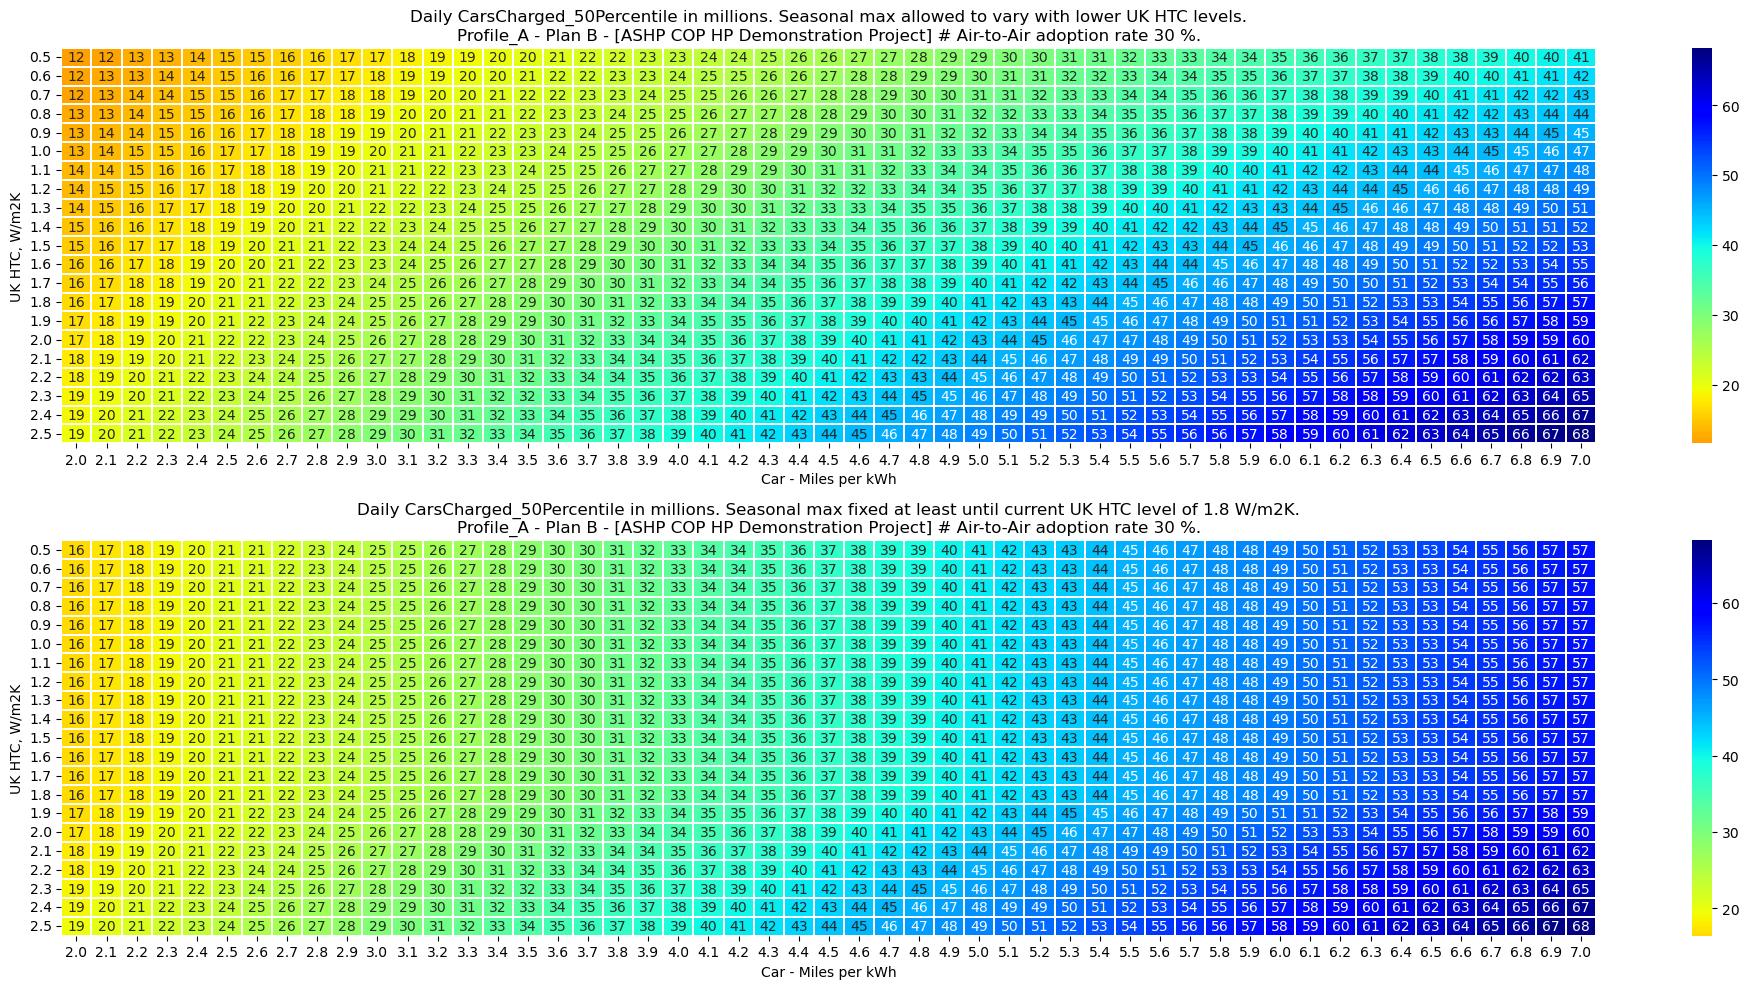

In [55]:
SummaryDF = pd.read_csv("3.Methodology/3_EV_Charging/EV_Charging_AllVariable_HP_COP_Demonstration.csv")
MaxDemand = ['MaxDemand_0Percentile','MaxDemand_25Percentile','MaxDemand_50Percentile','MaxDemand_75Percentile','MaxDemand_80Percentile','MaxDemand_100Percentile']
SummaryDF[MaxDemand] = SummaryDF[MaxDemand]/1000
value1 = 'CarsCharged_50Percentile';
Varient = 'ASHP COP HP Demonstration Project'
PvtTableCars = pd.pivot_table(SummaryDF, values=value1, columns='Car Miles per kWh', index= 'UK HTC')
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
sns.heatmap(PvtTableCars,cmap='jet_r',center=30,annot=True, fmt='.0f',linewidth=0.01)
plt.title(f"Daily {value1} in millions. Seasonal max allowed to vary with lower UK HTC levels.\n{CoolingProfileLabel} - Plan {Plan} - [{Varient}] # Air-to-Air adoption rate {AirToAirAdoptionRate} %.")
plt.xlabel("Car - Miles per kWh")
plt.ylabel("UK HTC, W/m2K")
plt.yticks(rotation=0)
#
SummaryDF = pd.read_csv("3.Methodology/3_EV_Charging/EV_Charging_FixedTill18_HP_COP_Demonstration.csv")
MaxDemand = ['MaxDemand_0Percentile','MaxDemand_25Percentile','MaxDemand_50Percentile','MaxDemand_75Percentile','MaxDemand_80Percentile','MaxDemand_100Percentile']
SummaryDF[MaxDemand] = SummaryDF[MaxDemand]/1000
PvtTableCars = pd.pivot_table(SummaryDF, values=value1, columns='Car Miles per kWh', index= 'UK HTC')
plt.subplot(2,1,2)
sns.heatmap(PvtTableCars,cmap='jet_r',center=30,annot=True, fmt='.0f',linewidth=0.01)
plt.title(f"Daily {value1} in millions. Seasonal max fixed at least until current UK HTC level of 1.8 W/m2K.\n{CoolingProfileLabel} - Plan {Plan} - [{Varient}] # Air-to-Air adoption rate {AirToAirAdoptionRate} %.")
plt.xlabel("Car - Miles per kWh")
plt.ylabel("UK HTC, W/m2K")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"3.Methodology/3_EV_Charging/EVChargingRelationshipWithHTC_And_Efficiency.png")

In [59]:
CoolingProfileLabel = 'Profile_A';CoolingProfile = Profiles[CoolingProfileLabel];
Plan = 'B';AirToAirAdoptionRate = 60;
Varient = 'ASHP COP HP Demonstration Project'
print(f"{CoolingProfileLabel} - Plan {Plan} - [{Varient}] # Air-to-Air adoption rate {AirToAirAdoptionRate} %.")
for UK_HTC in np.arange(0.5,2.6,0.1):
    UK_HTC = round(UK_HTC,1)
    DataTable = DataTableOption(Plan,AirToAirAdoptionRate,UK_HTC)
    MaxDemandWithHP = round(DataTable["Max Demand With HP"].max(),2)
    MaxDemandWithJustHP = round(DataTable["Day Max HPe"].max(),2)
    print(f"UK HTC {UK_HTC} W/m2K # Max Demand with HP: {MaxDemandWithHP} MWe # Max Demand with just HP: {MaxDemandWithJustHP} MWe.")

Profile_A - Plan B - [ASHP COP HP Demonstration Project] # Air-to-Air adoption rate 60 %.
UK HTC 0.5 W/m2K # Max Demand with HP: 69279.11 MWe # Max Demand with just HP: 11835.64 MWe.
UK HTC 0.6 W/m2K # Max Demand with HP: 71339.23 MWe # Max Demand with just HP: 14202.76 MWe.
UK HTC 0.7 W/m2K # Max Demand with HP: 73399.36 MWe # Max Demand with just HP: 16569.89 MWe.
UK HTC 0.8 W/m2K # Max Demand with HP: 75459.48 MWe # Max Demand with just HP: 18937.02 MWe.
UK HTC 0.9 W/m2K # Max Demand with HP: 77519.6 MWe # Max Demand with just HP: 21304.15 MWe.
UK HTC 1.0 W/m2K # Max Demand with HP: 79579.72 MWe # Max Demand with just HP: 23671.27 MWe.
UK HTC 1.1 W/m2K # Max Demand with HP: 81639.85 MWe # Max Demand with just HP: 26038.4 MWe.
UK HTC 1.2 W/m2K # Max Demand with HP: 83699.97 MWe # Max Demand with just HP: 28405.53 MWe.
UK HTC 1.3 W/m2K # Max Demand with HP: 85760.09 MWe # Max Demand with just HP: 30772.66 MWe.
UK HTC 1.4 W/m2K # Max Demand with HP: 87820.21 MWe # Max Demand with just 

In [9]:
CoolingProfileLabel = 'Profile_A';CoolingProfile = Profiles[CoolingProfileLabel];
Plan = 'B';AirToAirAdoptionRate = 60;
#Varient = 'ASHP COP HP Demonstration Project'
Varient = 'ASHP COP Literature'
print(f"{CoolingProfileLabel} - Plan {Plan} - [{Varient}] # Air-to-Air adoption rate {AirToAirAdoptionRate} %.")
for UK_HTC in np.arange(0.5,2.6,0.1):
    UK_HTC = round(UK_HTC,1)
    DataTable = DataTableOption(Plan,AirToAirAdoptionRate,UK_HTC)
    MaxDemandWithHP = round(DataTable["Max Demand With HP"].max(),2)
    MaxDemandWithJustHP = round(DataTable["Day Max HPe"].max(),2)
    print(f"UK HTC {UK_HTC} W/m2K # Max Demand with HP: {MaxDemandWithHP} MWe # Max Demand with just HP: {MaxDemandWithJustHP} MWe.")

Profile_A - Plan B - [ASHP COP Literature] # Air-to-Air adoption rate 60 %.
UK HTC 0.5 W/m2K # Max Demand with HP: 67780.54 MWe # Max Demand with just HP: 10130.01 MWe.
UK HTC 0.6 W/m2K # Max Demand with HP: 69540.95 MWe # Max Demand with just HP: 12156.02 MWe.
UK HTC 0.7 W/m2K # Max Demand with HP: 71301.36 MWe # Max Demand with just HP: 14182.02 MWe.
UK HTC 0.8 W/m2K # Max Demand with HP: 73061.76 MWe # Max Demand with just HP: 16208.02 MWe.
UK HTC 0.9 W/m2K # Max Demand with HP: 74822.17 MWe # Max Demand with just HP: 18234.02 MWe.
UK HTC 1.0 W/m2K # Max Demand with HP: 76582.58 MWe # Max Demand with just HP: 20260.03 MWe.
UK HTC 1.1 W/m2K # Max Demand with HP: 78342.99 MWe # Max Demand with just HP: 22286.03 MWe.
UK HTC 1.2 W/m2K # Max Demand with HP: 80103.4 MWe # Max Demand with just HP: 24312.03 MWe.
UK HTC 1.3 W/m2K # Max Demand with HP: 81863.8 MWe # Max Demand with just HP: 26338.04 MWe.
UK HTC 1.4 W/m2K # Max Demand with HP: 83624.21 MWe # Max Demand with just HP: 28364.04 M